<a href="https://colab.research.google.com/github/encoras/Artificial-Intelligence-Group/blob/master/Unet_mamba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
class MAMBA(nn.Module):
    def __init__(self, dim_n):
        super(MAMBA, self).__init__()

        # layer norm

        self.dim = dim_n
        self.norm = nn.LayerNorm(dim_n)
        self.mamba = Mamba(
            d_model=dim_n,
            d_state=16,
            d_conv=2,
            expand=4,
        )

    def forward(self, x):

        # mambos pradzia
        if x.dtype == torch.float16:
            x = x.type(torch.float32)
        B, C = x.shape[:2]
        #assert C == self.dim
        n_tokens = x.shape[2:].numel()
        img_dims = x.shape[2:]
        x_flat = x.reshape(B, C, n_tokens).transpose(-1, -2)
        x_norm = self.norm(x_flat)
        x_mamba = self.mamba(x_norm)
        x = x_mamba.transpose(-1, -2).reshape(B, C, *img_dims)
        # mambos pabaiga

        return x

In [ ]:
class Encoderis(nn.Module):
    def __init__(self, do_bn = True):
        super(Encoderis, self).__init__()
        self.block1 = self.inner_block(3, 32)
        self.block2 = self.inner_block(32, 64)
        self.block3 = self.inner_block(64, 128)
        self.block4 = self.inner_block(128, 256)
        self.block5 = self.inner_block(256, 384)
        self.mamba5 = MAMBA(384)
        self.mamba4 = MAMBA(256)
        self.mamba3 = MAMBA(128)
        self.mamba2 = MAMBA(64)
        self.mamba1 = MAMBA(32)

    def inner_block(self, in_c, out_c, maxpool = 2):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size = 3, stride = 1, padding = 1, bias = False),
            nn.BatchNorm2d(out_c),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),
            nn.Conv2d(out_c, out_c, kernel_size = 3, stride = 1, padding = 1, bias = False),
            nn.BatchNorm2d(out_c),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

    def forward(self, x):
        # 3, 150, 150
        h1 = self.block1(x) # 32, 75, 75
        h1 = self.mamba1(h1)## mamba
        h2 = self.block2(h1) # 64, 37, 37
        h2 = self.mamba2(h2)## mamba
        h3 = self.block3(h2) # 128, 18, 18
        h3 = self.mamba3(h3)## mamba
        h4 = self.block4(h3) # 256, 9, 9
        h4 = self.mamba4(h4)## mamba
        h5 = self.block5(h4) # 384, 4, 4
        h5 = self.mamba5(h5)## mamba

        return [h1, h2, h3, h4, h5]

https://arxiv.org/pdf/2402.04139.pdf
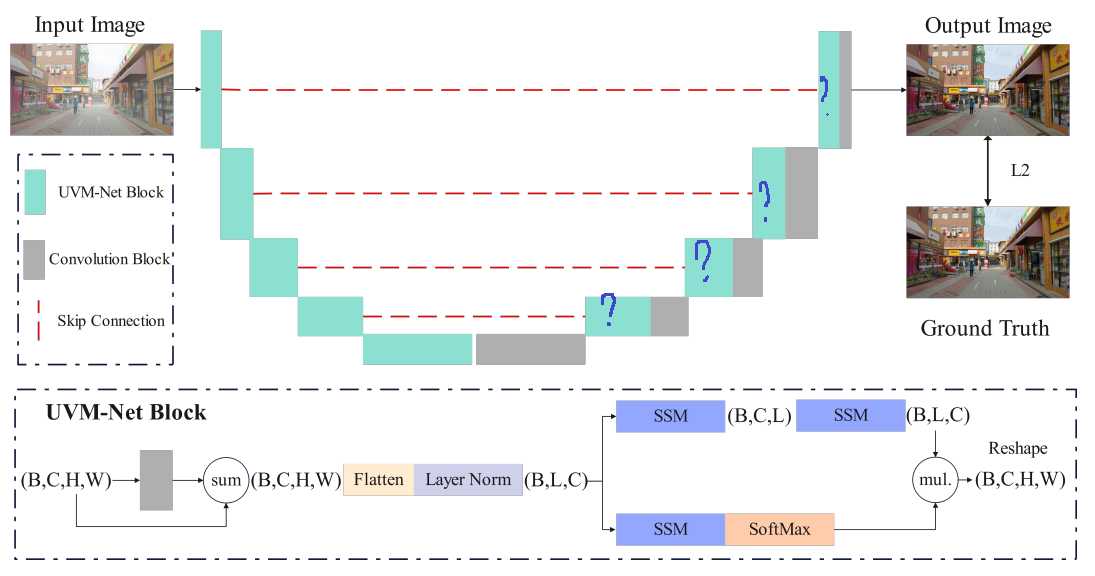

In [ ]:
class Decoderis(nn.Module):

    def __init__(self, do_bn = True):
        super(Decoderis, self).__init__()
        self.inner1 = self.inner_block(384, 256, 2, 0)
        self.inner2 = self.inner_block(256, 128, 4, 1)
        self.inner3 = self.inner_block(128, 64, 2, 0)
        self.inner4 = self.inner_block(64, 32, 2, 0)
        self.inner5 = self.inner_block(32, 3, 4, 1, out = True)

        self.cb1 = self.conv_block(512, 256)
        self.cb2 = self.conv_block(256, 128)
        self.cb3 = self.conv_block(128, 64)
        self.cb4 = self.conv_block(64, 32)


    def inner_block(self, in_c, out_c, kernel_size, padding, out = False,):
        return  nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, kernel_size = kernel_size, stride = 2, padding = padding, bias = False),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Conv2d(out_c, out_c, kernel_size = 3, stride = 1, padding = 1),
            nn.LeakyReLU() if not out else nn.Sigmoid(),
            nn.Dropout(0.2) if not out else nn.Identity(),
        )

    def conv_block(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, 1, 1, bias = False),
            nn.BatchNorm2d(out_c),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

    def forward(self, h):

        # 384, 5, 5
        x = h[-1]
        x = self.inner1(x)         # 256, 9, 9

        x = torch.concat([x, h[-2]], dim = 1)
        #<<<---------------------------------------------mamba?
        x = self.cb1(x)
        #<<<---------------------------------------------mamba?
        x = self.inner2(x)         # 128, 20, 20

        x = torch.concat([x, h[-3]], dim = 1)
        x = self.cb2(x)
        x = self.inner3(x)         # 64, 40, 40

        x = torch.concat([x, h[-4]], dim = 1)
        x = self.cb3(x)
        x = self.inner4(x)         # 32, 80, 80

        x = torch.concat([x, h[-5]], dim = 1)
        x = self.cb4(x)
        x = self.inner5(x)         # 3, 160, 160

        return x

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.encoder = Encoderis(do_bn = True)
        self.decoder = Decoderis(do_bn = True)


    def forward(self, x):

        h = self.encoder(x)

        h = self.decoder(h)
        return h